# <b>Fire - Weather - Index</b>

## Problem Setting

The problem setting of this project is to predict the affected area (in hectar) by wild fires based on wheather data. Based on the prediction of the by fire affected area, weather data can be reconciled and used to assess the threat of a wild fire. Given dataset of the Fire-Wheather-Index (FWI) $D = {x_i, y_i} $ where i ranges from 1 to n and n is the total number of instances ($n = 517$) a model should be learned that maps input attributes $ x_i $ to target variable $y_i$. Each instance $x_i$ is a vector with 12 attributes: 

- <b>X</b>     (X-coordinate of the fire in the park: $1$ to $9$)
- <b>Y</b> (Y-coordinate of the fire in the park: $2$ to $9$)
- <b>month</b>    ("jan" to "dec")
- <b>day</b>   (day: "mon" bis "sun")
- <b>FFMC</b>  (FFMC index of the FWI system: $18.7$  to  $96.2$)
- <b>DMC</b>   (DMC index of the FWI system: $1.1$ to $291.3$)
- <b>DC</b>    (DC index of the system: $7.9$ bis $860.6$)
- <b>ISI</b>   (ISI index of the FWI systems: $0.0$ to $56.1$)
- <b>temp</b>  (temperature in degrees Celsius: $2.2$ to $33.3$)
- <b>RH</b> (relative humidity in %: $15$ to $100$)
- <b>wind</b> (wind velocity in $km/h: 0.4$ to $9.4$)
- <b>rain</b> (rainfall in $mm/m^2$ : $0.0$ to $6.4$)

The target variable $area$ expresses the forest area that has been burnt in hectare: $0.09$ to $1090.84$. Since the target variable is continous this is a regression problem.

Which Methods? : 
- > Linear Regression as basline model
- > Neural Networks
- > Random Forests



In [111]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler as MinMax # MinMax Scaler
from sklearn.preprocessing import StandardScaler as zscore # zscore

raw_df = pd.read_csv("./rawdata/fires.csv", sep=",")
# print(np.shape(raw_df.values))
col_names = raw_df.columns

# print(col_names[12])
# print(np.shape(col_names))

## extracting data
# eig sinds 13 columns, aber mit pd.DataFrame gibts hier eine extra column (Index), 

fire_data = pd.DataFrame(raw_df.values) #pd datafram


fire_data.columns = col_names # use columns names for dataframe

## object to convert numeric columns
# errors='coerce' to replace any non-numeric values with NaN.
fire_data[fire_data.columns.difference(["month", "day"])] = fire_data[fire_data.columns.difference(["month", "day"])].apply(pd.to_numeric, errors='coerce')
# check datafram types : 
# print(fire_data.dtypes)

fire_data_dex= fire_data.copy() # dataframe solely for data exploration
# fire_data_dex = fire_data caution! this would just create a reference to the same memory place 



## Data Exploration and Preprocessing

### Data Exploration


In [112]:
## Integer Mapping for categorical features
#fire_data_dex = fire_data # dataframe solely for data exploration
# ordinal relationship introduced
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12} 

fire_data_dex["month"] = list(map(lambda x: month_dict[x], fire_data_dex["month"]))
day_dict = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5,'sat': 6, 'sun':7 }
fire_data_dex["day"] = list(map(lambda x: day_dict[x], fire_data_dex["day"]))

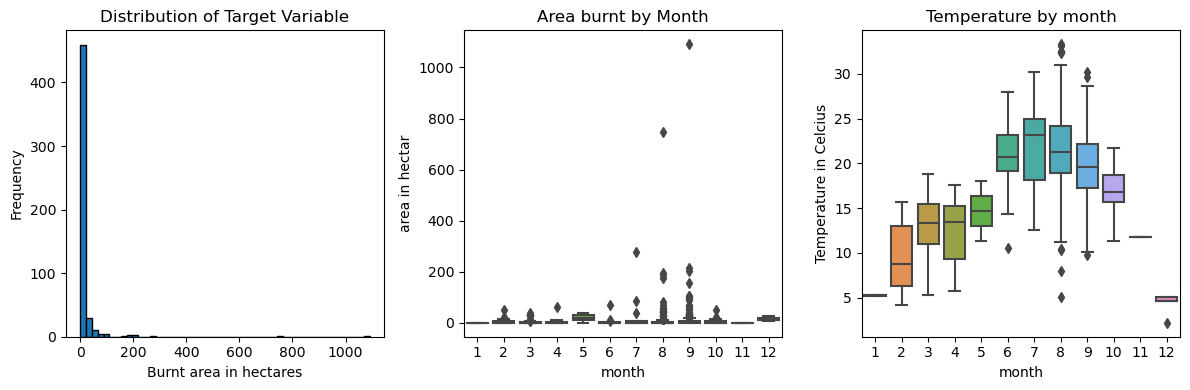

In [113]:

# figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 2 columns

# plot the histogram on the left subplot
axes[0].hist(fire_data_dex['area'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Target Variable')
axes[0].set_xlabel('Burnt area in hectares')
axes[0].set_ylabel('Frequency')

# plot the boxplot on right subplot
sns.boxplot(data=fire_data_dex, x='month', y=fire_data_dex['area'], ax=axes[1])
axes[1].set_title('Area burnt by Month')
axes[1].set_ylabel('area in hectar')
# plot the boxplot on right subplot
sns.boxplot(data=fire_data_dex, x='month', y='temp', ax=axes[2])
axes[2].set_title('Temperature by month')
axes[2].set_ylabel('Temperature in Celcius')
# Display the plots
plt.tight_layout()  # spacing between plots
plt.show()

## Plot burnt area with respect to X,Y >> include into learning if seem to be patterns related to the spatial location


- Imbalanced Target: Burnt Area 
- Check Correlation between month and temp

### Data Exploration: Numeric Summary
- distribution types
- area non-uniformly :  area'= log(1 + area) logarithmic scaling, use with exponential grow patterns
- Z-score normalization, for linear regression w/ L2 regularizer

In [114]:
# numeric columns in the DataFrame
# numeric_columns = fire_data.select_dtypes(include=[np.number])
summary = fire_data_dex.drop(columns=["day","month"]).describe()

# Print the summary
print(summary)
 ## !visualize distribution for each column
 ## not for the coordinates 




                X           Y        FFMC         DMC          DC         ISI   
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000  \
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655

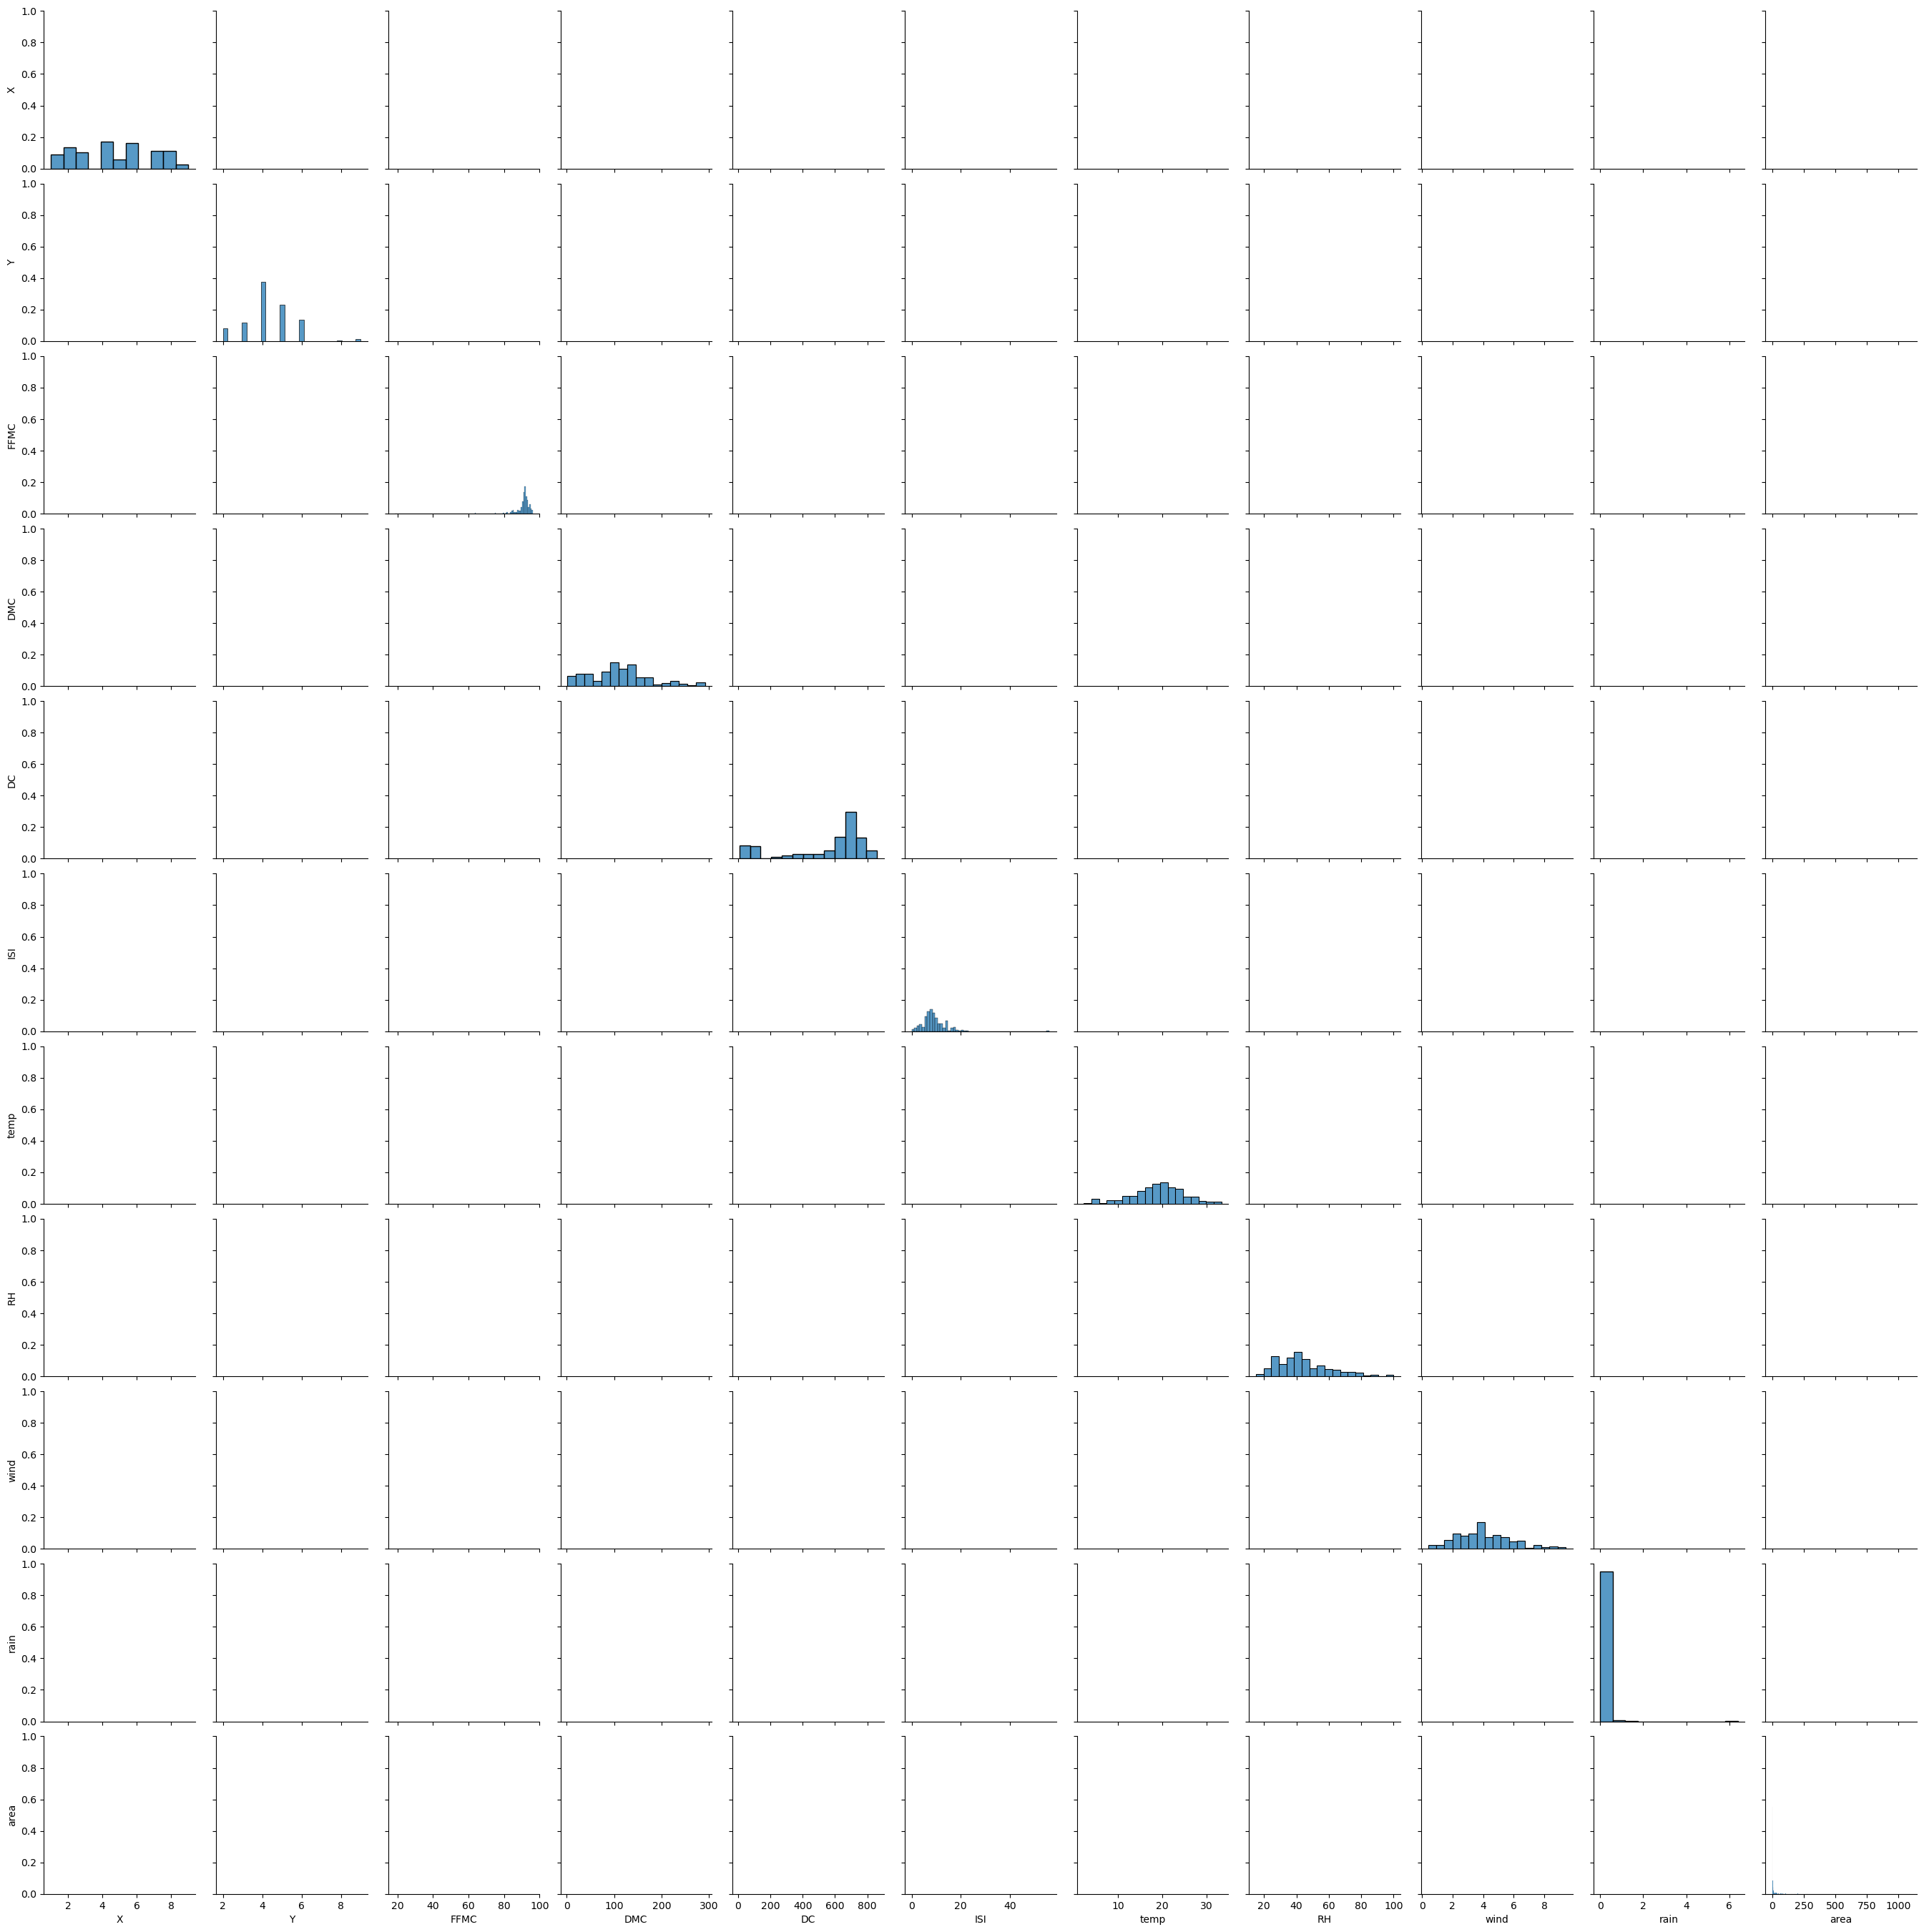

In [115]:
# create PairGrid
g = sns.PairGrid(fire_data_dex[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']])
g = g.map_diag(sns.histplot)  # histograms on diagonal
#g = g.map_offdiag(sns.scatterplot)  # scatter plots off-diagonal
plt.show()


### Scaling/Normalization for Linear Regression and Neural Network

| Feature | Scaling/Norm        | Scale        | Reason  |
|---------|---------------------|--------------|---------|
| area    | log(1 + area)       | (0 - 1)      | Skewness, many zeros: add const=1, high values: log |
| rain    |  log(1 + rain)+MinMax| (0 - 1)      | Outliers+many zeros |
| wind    | z-score             | (zero - mean)| Small range, platt verteilung |
| RH      | log(1 + RH), z-score             | (zero - mean)| positive skewness, Widely spread |
| temp    | z-score             | (zero - mean)| Normally distributed, no outliers, let's normalize |
| ISI     | z-score             | (zero - mean)| Normalize, max far away from 78% percentile |
| DC      | z-score             | (zero - mean)| Normalize, wide range and slight skewness |
| DMC     | z-score             | (zero - mean)| Widely spread, platt verteilung |
| FFMC    | z-score             | (zero - mean)| Clustered around mean 90, outliers on low side |
| X & Y   | Min/Max             | (0 - 1)      | To account for limited range, but keep intuitive character (no negative values) |

side note: 
> z-score is outlier robust

> Min/Max outlier sensitive

In [116]:
#  area
fire_data_dex['area_log'] = fire_data_dex['area'].apply(lambda x: np.log(1 + x))
# rain
fire_data_dex['rain_logminmax'] = fire_data_dex['rain'].apply(lambda x: np.log(1 + x))
fire_data_dex['rain_logminmax'] = MinMax().fit_transform(fire_data_dex[['rain_logminmax']])

# multiple columns z-scoring
#from sklearn.preprocessing import StandardScaler as zscore
to_zscore = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind']
zscored_col = [col + '_zs' for col in to_zscore]
fire_data_dex[zscored_col] = zscore().fit_transform(fire_data_dex[to_zscore])

## Skewness
# RH_zs, positve/right Skewness, log Transformation (x = log(c+x))
# DC_zs, negative/left Skewness, inverse Transformation (1/x)
fire_data_dex['RH_logzs'] = fire_data_dex['RH'].apply(lambda x: np.log(1 + x))
fire_data_dex['RH_logzs'] = zscore().fit_transform(fire_data_dex[['RH_logzs']])
# fire_data_dex['DC_invzs'] = fire_data_dex['DC'].apply(lambda x: 1/x if x != 0 else 0)
# fire_data_dex['DC_invzs']= zscore().fit_transform(fire_data_dex[['DC_invzs']])
#fire_data_dex = fire_data_dex.drop(columns=['RH_zs', 'DC_zs'])


# X Y - coordinates, MinMax Transform
to_minmax = ['X', 'Y']
minmaxed_col = [col + '_minmax' for col in to_minmax]
fire_data_dex[minmaxed_col] = MinMax().fit_transform(fire_data_dex[to_minmax])



In [117]:
# numeric columns in the DataFrame
summary = fire_data_dex.drop(columns=['X', 'Y','day','month','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain','area']).describe()

# Print the summary
print(summary)
 ## !visualize distribution for each column
 ## not for the coordinates 



         area_log  rain_logminmax       FFMC_zs        DMC_zs         DC_zs   
count  517.000000      517.000000  5.170000e+02  5.170000e+02  5.170000e+02  \
mean     1.111026        0.005264 -1.752306e-15 -2.748715e-17  6.871787e-17   
std      1.398436        0.054173  1.000969e+00  1.000969e+00  1.000969e+00   
min      0.000000        0.000000 -1.304582e+01 -1.715608e+00 -2.179108e+00   
25%      0.000000        0.000000 -8.063453e-02 -6.606652e-01 -4.448281e-01   
50%      0.418710        0.000000  1.732292e-01 -4.020255e-02  4.691190e-01   
75%      2.024193        0.000000  4.089598e-01  4.927389e-01  6.696628e-01   
max      6.995620        1.000000  1.007353e+00  2.819865e+00  1.261610e+00   

             ISI_zs       temp_zs       wind_zs      RH_logzs    X_minmax   
count  5.170000e+02  5.170000e+02  5.170000e+02  5.170000e+02  517.000000  \
mean   1.030768e-17  2.542561e-16 -4.191790e-16  1.230050e-15    0.458656   
std    1.000969e+00  1.000969e+00  1.000969e+00  1.000969

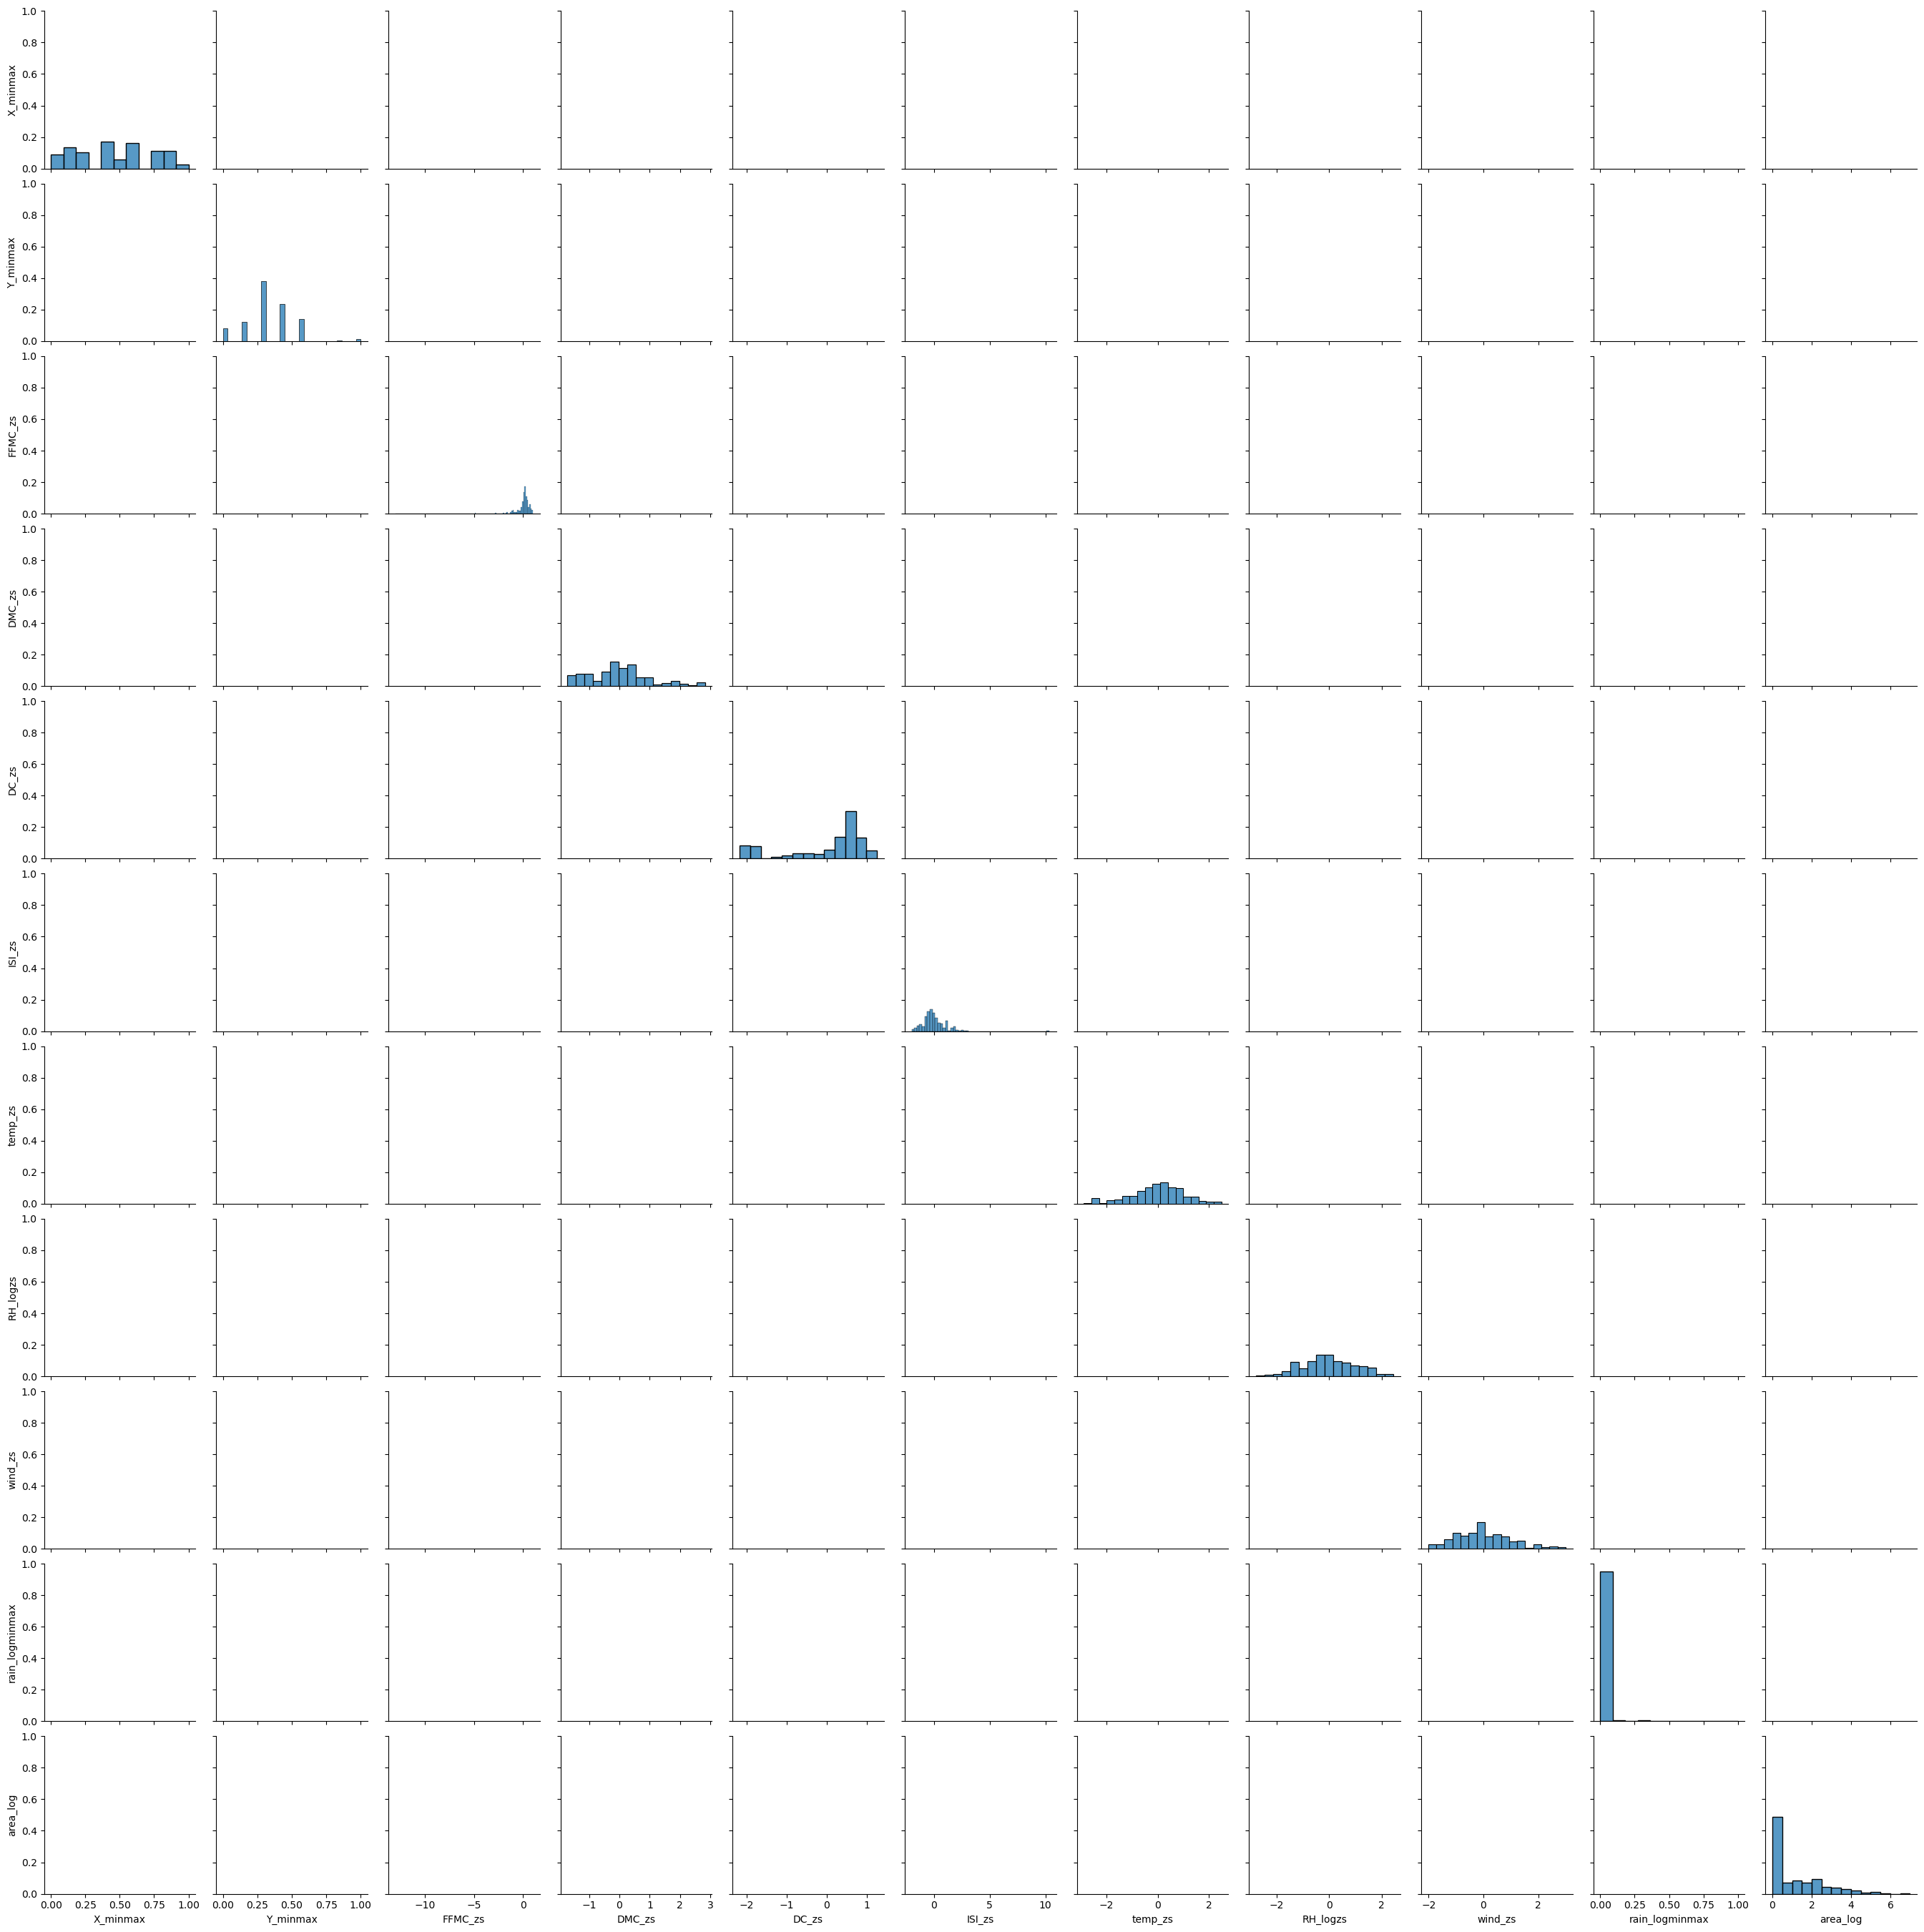

In [118]:
# create PairGrid
g = sns.PairGrid(fire_data_dex[['X_minmax', 'Y_minmax', 'FFMC_zs', 'DMC_zs', 'DC_zs', 'ISI_zs', 'temp_zs', 'RH_logzs', 'wind_zs', 'rain_logminmax', 'area_log']])
g = g.map_diag(sns.histplot)  # histograms on diagonal
#g = g.map_offdiag(sns.scatterplot)  # scatter plots off-diagonal
plt.show()



### Preprocessing
#### One-Hot-Encoding

Avoid ordinal Relationshipt : Jan lt Feb. Mo lt Tuesday

Expanding feature space, making dataset sparse -> increase computation

Regarding one-hot-encoding "day" and "month" cardinality would increase.
We would increase coloumn count by 19 (7 + 12)




### Prepocessing Pipline

In [119]:
def preproc_df(df, target, standardize = True, skew=False):
    """
    Preprocess Dataframe fire_data according to Dataexploration

    Parameters:
    - df (DataFrame): input DataFrame (fire_data) 
    - target (Series): target variable (pd series)
    - standardize (bool, default: True): if True: perform standardization on specified columns
    - skew (bool, default: False): effective only if standardize=False, skew=True applies skewness correction to the 'RH' column. 

    returns:
    - processed_df (dataframe)
    - processed_target (pd series)
    """

    processed_df = df.copy()  # cpy of the input df to avoid modifying directly
    processed_target = target.copy()

    if standardize:
      print(" Preprocessing: standardized")
      # log transform and scale 'area' column
      #processed_df['area_log'] = processed_df[target].apply(lambda x: np.log(1 + x))
      processed_target = target.apply(lambda x: np.log(1 + x))
      processed_target.name = 'area_log'

      # log transform and Min-Max scale 'rain' column
      processed_df['rain_logminmax'] = processed_df['rain'].apply(lambda x: np.log(1 + x))
      processed_df['rain_logminmax'] = MinMax().fit_transform(processed_df[['rain_logminmax']])
      
      #z-score scaling for specified columns
      to_zscore = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind']
      zscored_col = [col + '_zs' for col in to_zscore]
      processed_df[zscored_col] = zscore().fit_transform(processed_df[to_zscore])
      
      # skewness adjustments
      processed_df['RH_logzs'] = processed_df['RH'].apply(lambda x: np.log(1 + x))
      processed_df['RH_logzs'] = zscore().fit_transform(processed_df[['RH_logzs']])
      
      # Min-Max scaling for coordinates
      to_minmax = ['X', 'Y']
      minmaxed_col = [col + '_minmax' for col in to_minmax]
      processed_df[minmaxed_col] = MinMax().fit_transform(processed_df[to_minmax])
      
      # One-hot encoding
      processed_df = pd.get_dummies(processed_df, columns=['month', 'day'])
      processed_df = processed_df.drop(columns=["day_sun", "month_dec"])
      
      # drop the original, unprocessed columns
      columns_to_drop = to_zscore + to_minmax + ['rain', 'RH', 'month', 'day']
    else:
      print(" Preprocessing: One-Hot encode only")
      # One-hot encoding
      processed_df = pd.get_dummies(processed_df, columns=['month', 'day'])
      processed_df = processed_df.drop(columns=["day_sun", "month_dec"])

      # toggle skewness and test w/ and w/o
      if skew:
        # skewness adjustments
        print('with Skewness Adjustment')
        processed_df['RH_logzs'] = processed_df['RH'].apply(lambda x: np.log(1 + x))
        processed_df['RH_logzs'] = zscore().fit_transform(processed_df[['RH_logzs']])
        # drop the original, unprocessed columns
        columns_to_drop = ['month', 'day', 'RH']
      else:
        # drop the original, unprocessed columns
        columns_to_drop = ['month', 'day']
    
    processed_df = processed_df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' in case some columns dont exist

    return processed_df, processed_target


### Training

> Linear Regression with L2 (ridge) regularizer (hyperparameter: lambda)
- L2: because shrinks coefficients (instead of turning them to zero like lasso) which is better for a small dataset
- also there could be correlation between features thereby keeping them is safer ?


### Evluation
- split: 80/20%
    - 80% (for cross validation), 
    - 20% (hold-out) later after training
- k-fold cross validation 
    - stratified sampling and splitting 
- evaluate regression models using the Root Mean Squared Error (RMSE). 
    - useful when you want to interpret the error in the original units of the target variable. 
        > area was log transformed, when do I revert? 

    - higher weight to larger errors due to squaring


$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

where:

- \( n \) is the number of observations,
- \( y_i \) is the actual value of the target variable for observation \( i \),
- $\hat{y}_i$ is the predicted value of the target variable for observation \( i \).






In [120]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.linear_model import LinearRegression  ## LR
from sklearn.model_selection import learning_curve

from sklearn.linear_model import Ridge #LRridge
from sklearn.neural_network import MLPRegressor     ## NN
from sklearn.ensemble import RandomForestRegressor  ## RF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [121]:
def get_model(model_name):
    if model_name == 'randomForest':
        return RandomForestRegressor()
    elif model_name == 'ridgeRegression':
        print('ridgeRegression')
        return Ridge()
    elif model_name == 'MLPRegressor':
        return MLPRegressor()

In [138]:
def evaluate_model3(df, target, model, standardize, param_grid, thr_bins = [-np.inf, 0.01, 0.52, 6.57, 1090.84], bin_label=[1,2,3,4], kfolds=5, skew=False, plot = False):
    """
    Parameters:
    - df: DataFrame
    - target: str, target variable.
    - model: scikit-learn model (regression)
    - standardize: bool, standardize (from preproc_df).
    - thr_bins: list, thresholds for binning target variable.
    - skew: bool, apply skewness correction for RH (from preproc_df, if standardize=False).
    - plot: bool
    - param_grid: dict, parameter grid for GridSearchCV
    
    Returns:
    (plot=False):
        - RMSE scores 
    (plot=True):
        - learning curve
        - train_scores RSME scores from cross-validation
    """

    ##### PREPROCESSING
    X, y = preproc_df(df, target, standardize, skew)

    ##### SAMPLING
    # creating bins for target, startified sampling
    bins = pd.cut(y, bins=thr_bins, labels=bin_label)
    # stratified sampling needed for each fold
    # .split(X,y_labels) method for StratifiedKFold: "Generate indices to split data into training and test set."
    # is normally used for classification task with classes as target, but since target is binned 
    # .split() could be used for stratified sampling
    strat_kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=35007).split(X, bins)
    # returns indices for stratified training and test sets based on the binning
    # stratified sampling indeces use for crossvalidation
    
    #### GRID SEARCH, CROSSVALIDATION, FITTING
    grid_searchcv = GridSearchCV(model, param_grid=param_grid, cv=strat_kf, scoring='neg_mean_squared_error').fit(X, y)
    # fetch model for return
    tuned_model = grid_searchcv.best_estimator_ 
    # RMSE, negate because scoring neg_mean_sqared_error ouput negative MeanSquaredError
    rmse_score = np.sqrt(-grid_searchcv.best_score_)
    
    #### RETURN
    if not(plot):
        return rmse_score, tuned_model
    else:
        # strat_kf generator will get consumed by gridsearhc
        # redeclare
        strat_kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=35007).split(X, bins)
        train_sizes, train_scores, test_scores = learning_curve(
            tuned_model, 
            X, y, 
            cv=strat_kf, 
            scoring='neg_mean_squared_error', 
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        # train_sizes=np.linspace(0.1, 1.0, 10): validation scores for 10% to 100% of the training data (increasing size of the training set by 10%)
        # np.linspace(0.1, 1.0, 10): from 0.1 to 1, 10 values equally spaced
        
        train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
        test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
        
        plt.figure()
        plt.title("Learning Curve")
        plt.xlabel("Size of Training Set")
        plt.ylabel("Mean RMSE Score")
        plt.grid()
        
        # x-axis actual size of the training set (10%-100%)
        # y-axis the RMSE 
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.legend(loc="best")
        plt.show()
        return np.sqrt(-train_scores), tuned_model


#### Creating 80/20% Hold-Out Set
- Many zero values (skewed) use stratified sampling to ensure same distribution in splits
Basing bin edges for stratified sampling on the distribution of area (target):

| Statistic | Value       |
|-----------|-------------|
| Count      | 517.000000  |
| Mean      | 12.847292   |
| Std       | 63.655818   |
| Min       | 0.000000    |
| 25%       | 0.000000    |
| 50%       | 0.520000    |
| 75%       | 6.570000    |
| Max       | 1090.840000 |


> Bin 1: 0 to 0 (Q1)                technically : -inf to 0.01

> Bin 2: >0 to 0.52 (Q2/Median)

> Bin 3: >0.52 to 6.57 (Q3) 

> Bin 4: >6.57 to 1090.84 (Max)


In [123]:
bins = pd.cut(fire_data['area'], bins=[-np.inf, 0.01, 0.52, 6.57, 1090.84], labels=[1, 2, 3, 4])
# warning from splitting, in StratifiedKfold: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
# warnings.warn( <<< do fewer bins?
# bins = pd.cut(fire_data['area'], bins=[-np.inf, 0.01, 0.52, 1090.84], labels=[1, 2, 3])

X_train, X_test, y_train, y_test = train_test_split(fire_data.drop('area', axis=1), fire_data['area'], test_size=0.2, stratify=bins, random_state=35007)


#### Hyperparameter Tuning

> Ridge Regression (L2 regularizer):

$$\text{Objective} = ||y - X\beta||^2_2 + \alpha ||\beta||^2_2$$

$\alpha$: regularization strength
- the larger the stronger the regularization
- shrinking the coefficients $\beta$ toward zero (possibly simpler model)

fit_intercept: 
- allow and calculate intercept $y=X\beta+b$
- if False forcing hyperplane to pass origin

> Random Forest:

n_estimator: number of trees in forest
- more trees, more opportunity to learn from data, better performance
- more trees more computation time, at some number no significant increase in performance

max_depth: max depth of each decision tree
- more depth, more complexity, potentially captureing complexity of data
- more depth higher chance of overfitting, less depth underfitting
- deeper trees more computational effort



##### Ridge Regression

ridgeRegression
 Preprocessing: standardized


/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


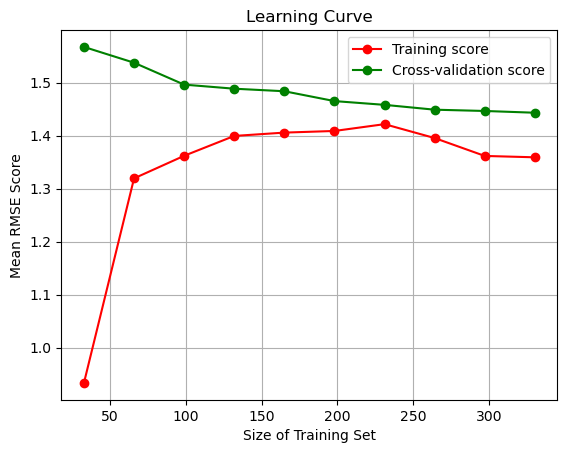

(array([[0.96504152, 0.97479174, 0.88944056, 0.82995644, 1.00927822],
        [1.3566392 , 1.29537603, 1.3798923 , 1.17950685, 1.3854253 ],
        [1.33506646, 1.33220944, 1.38572423, 1.33723731, 1.41945063],
        [1.37859798, 1.42486062, 1.40262114, 1.35464614, 1.43626497],
        [1.33329554, 1.41245422, 1.38466512, 1.41541435, 1.48248938],
        [1.36031053, 1.43195496, 1.38093366, 1.42316617, 1.44746305],
        [1.35346275, 1.43827514, 1.40581569, 1.44314294, 1.46733686],
        [1.32075708, 1.40694779, 1.39167403, 1.41631456, 1.44121374],
        [1.29851352, 1.36696426, 1.3578789 , 1.38116946, 1.40385646],
        [1.30300663, 1.34783386, 1.36184417, 1.3787044 , 1.40411703]]),
 Ridge(alpha=3.5))

In [145]:
a_model = get_model(model_name='ridgeRegression')
param_grid = {"alpha": np.array(np.arange(1, 4, 0.5)), "fit_intercept": [False, True]}
# fit_intercept seems to be always chosen as true, model returned withouth the parameter, 
# but if i force to be [False, False] then model will be returned with fit_intercept=False.  
binning = [-np.inf, 0.01, 0.52, 6.57, 1090.84]
bin_label = [1, 2, 3, 4]

evaluate_model3(X_train, y_train, 
                a_model, 
                param_grid=param_grid,
                standardize=True, 
                thr_bins=binning, 
                bin_label=bin_label,  
                kfolds=5, 
                plot=True)





##### Random Forest

 Preprocessing: standardized


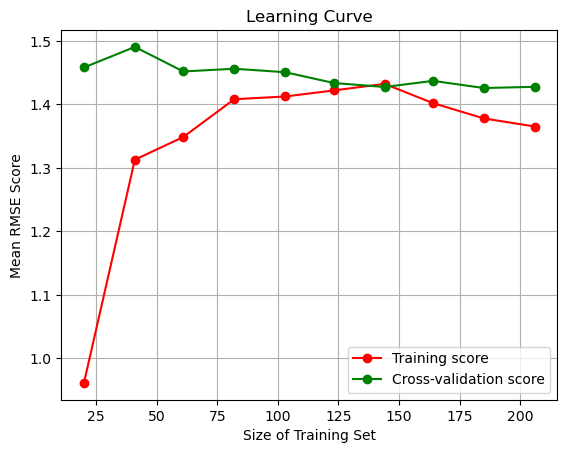

(array([[1.07378789, 0.84929141],
        [1.35618636, 1.26982915],
        [1.29449187, 1.40298836],
        [1.35491317, 1.46145978],
        [1.34565995, 1.47928005],
        [1.37748208, 1.46648238],
        [1.34237123, 1.52237043],
        [1.30867145, 1.49532774],
        [1.28637818, 1.46939163],
        [1.27109055, 1.45933509]]),
 RandomForestRegressor(max_depth=1, n_estimators=45))

In [154]:
a_model = get_model(model_name='randomForest')
param_grid = {"n_estimators": np.array(np.arange(43, 47, 1)), "max_depth": np.array(np.arange(1, 5, 1))}
binning = [-np.inf, 0.01, 0.52, 6.57, 1090.84]
bin_label = [1, 2, 3, 4]

evaluate_model3(X_train, y_train, 
                a_model, 
                param_grid=param_grid,
                standardize=True, 
                thr_bins=binning, 
                bin_label=bin_label,  
                kfolds=2, 
                plot=True)



